# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

**Импортируем библиотеки**

In [1]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords as stopwords_nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

**Загрузим и изучим данные**

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
display(df.info())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


,text,toxic
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159567,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159568,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159569,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159570,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


<function matplotlib.pyplot.show(*args, **kw)>

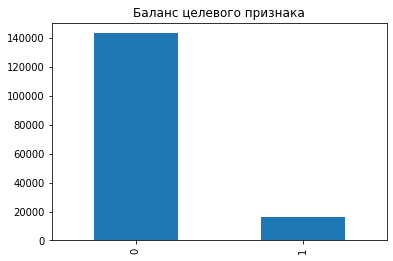

In [4]:
df['toxic'].value_counts().plot(kind='bar')
plt.title('Баланс целевого признака')
plt.show

Вывод:
  - пропусков нет
  - английский текст
  - лишние символы в тексте
  - есть дисбаланс классов

**Подготовка данных**

In [5]:
#очистим от лишних символов и приведем к нижнему регистру

def remove_punctuation(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

df['punctuation_free'] = df['text'].apply(lambda x: remove_punctuation(x.lower()))
df.head(3)

,text,toxic,punctuation_free
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info


In [6]:
#удалим стоп-слова

stop_words = set(stopwords_nltk.words('english'))  

def remove_stopwords(text):
    clean_text = [w for w in text.split() if not w in stop_words]  
    return clean_text

df['stopwords_free'] = df['punctuation_free'].apply(lambda x: remove_stopwords(x))
df.head(3)

,text,toxic,punctuation_free,stopwords_free
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]"


In [7]:
#проведем лемматизацию

lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    clean_text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(clean_text)

df['lemmas'] = df['stopwords_free'].apply(lambda x: lemmatize_text(x))
df.head(3)

,text,toxic,punctuation_free,stopwords_free,lemmas
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]",explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]",aww match background colour seemingly stuck thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]",hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info


In [8]:
#выделим целевой признак и признаки

target = df['toxic']
features = df.drop('toxic', axis = 1)

print('Целевой признак:', target.shape)
print('Признаки:', features.shape)

Целевой признак: (159571,)
Признаки: (159571, 4)


In [9]:
#разделим данные в соотношении 80/20

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=0.80, 
                                                                            test_size=0.20, 
                                                                            random_state=123)

In [10]:
#проверим размер выборки

print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (127656, 4)
Размер тестовой выборки: (31915, 4)


In [11]:
corpus_train = features_train['stopwords_free'].astype('U')
corpus_test = features_test['stopwords_free'].astype('U')

In [12]:
#вычислим TF-IDF для корпуса текстов

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit(corpus_train)

In [13]:
train_X = tf_idf.transform(corpus_train)
test_X = tf_idf.transform(corpus_test)

Данные подготовили переходим к обучению

## Обучение

Обучим следующие модели:

  - LogisticRegression
  - RandomForestClassifier
  - DecisionTreeClassifier
  - Stochastic Gradient Descent Classifier

**LogisticRegression**

In [14]:
model = LogisticRegression(random_state=123, class_weight='balanced', solver='liblinear') 
model.fit(train_X, target_train)
predictions = model.predict(test_X)

f1 = f1_score(target_test, predictions)
print('LogisticRegression:', f1)

LogisticRegression: 0.7507632528448515


Хорошо

**RandomForestClassifier**

In [15]:
%%time
results_rfc = []

for depth in range(1,11):
    
    for estimator in range(10, 51, 10):
        
        model = RandomForestClassifier(random_state=123, 
                                       class_weight = 'balanced', 
                                       n_estimators=estimator, 
                                      max_depth=depth) 
        
        model.fit(train_X, target_train)
        predictions = model.predict(test_X)

        f1 = f1_score(target_test, predictions)
        results_rfc.append({'Model': 'RandomForestClassifier', 
                            'Hyperparameters': {'random_state': 123, 
                                                'class_weight': 'balanced',
                                                'n_estimators': estimator, 
                                                'max_depth':depth}, 
                            'F1 score': f1})

CPU times: user 1min 21s, sys: 79.6 ms, total: 1min 21s
Wall time: 1min 22s


In [16]:
pd.DataFrame(results_rfc).style.highlight_max(color = 'lightgreen', axis = 0)

,Model,Hyperparameters,F1 score
0,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 10, 'max_depth': 1}",0.198324
1,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 20, 'max_depth': 1}",0.209658
2,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 30, 'max_depth': 1}",0.227435
3,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 40, 'max_depth': 1}",0.235362
4,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 50, 'max_depth': 1}",0.248481
5,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 10, 'max_depth': 2}",0.223658
6,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 20, 'max_depth': 2}",0.243474
7,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 30, 'max_depth': 2}",0.248766
8,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 40, 'max_depth': 2}",0.254417
9,RandomForestClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'n_estimators': 50, 'max_depth': 2}",0.260591


In [17]:
def grid(model, params, feat, targ):
    
    search = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='f1')
    search.fit(feat, targ)
    
    print('Best score = ', search.best_score_)
    print(search.best_params_)

In [18]:
params = dict(class_weight = ['balanced'], 
              n_estimators=range(10,51,10),
              max_depth=range(1,11))

model = RandomForestClassifier(random_state=123)

In [19]:
%%time
grid(model, params, train_X, target_train)

Best score =  0.33748062756786357
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}
CPU times: user 21min 6s, sys: 5.92 s, total: 21min 12s
Wall time: 21min 28s


**DecisionTreeClassifier**

In [20]:
results_dtc = []

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth, class_weight = 'balanced')
    model.fit(train_X, target_train)
    predictions = model.predict(test_X)

    f1 = f1_score(target_test, predictions)

    results_dtc.append({'Model': 'DecisionTreeClassifier', 
                        'Hyperparameters': {'random_state': 123, 
                                            'class_weight': 'balanced', 
                                            'max_depth': depth},
                        'F1 score': f1})

In [21]:
pd.DataFrame(results_dtc).style.highlight_max(color = 'lightgreen', axis = 0)

,Model,Hyperparameters,F1 score
0,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 1}",0.28378
1,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 2}",0.372474
2,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 3}",0.372474
3,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 4}",0.430859
4,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 5}",0.434067
5,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 6}",0.474584
6,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 7}",0.507188
7,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 8}",0.536114
8,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 9}",0.557738
9,DecisionTreeClassifier,"{'random_state': 123, 'class_weight': 'balanced', 'max_depth': 10}",0.554817


Лучше чем отстой

**Stochastic Gradient Descent Classifier**

In [22]:
model = SGDClassifier(alpha=1e-05, penalty='l1', random_state=123) 
model.fit(train_X, target_train)
predictions = model.predict(test_X)

f1 = f1_score(target_test, predictions)
print('Stochastic Gradient Descent Classifier:', f1)

Stochastic Gradient Descent Classifier: 0.7842086459449803


## Выводы

Во время проекта:

1) изучили и подготовили данные:

 - посмотрели общую информацию о данных
 - убедились, что пропуски отсутствуют
 - провели предобработку текста (удалили лишние символы, убрали стоп-слова)

2) обучили следующие модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier и Stochastic Gradient Descent Classifier. Только модель LogisticRegression и Stochastic Gradient Descent Classifier справилась с поставленной задачей - достичь метрику качества F1 не меньше 0.75.

Интересно, что такие модели как RandomForestClassifier и DecisionTreeClassifier в этой задаче показали гораздo хуже результат нежели LogisticRegression и Stochastic Gradient Descent Classifier. К тому же, настройка гиперпараметров значительно ухудшила работу этих моделей. Также стоит отметить, что эти модели обучаются гораздо дольше.

Результат: как наилучшую модель для классификации комментариев можно рекомендовать модель Stochastic Gradient Descent Classifier с гиперпараметрами alpha=1e-05, penalty='l1', которая дает результат F1 = 0.78.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны